# Training and evaluating Singing Voice Detectors

In [1]:
import sys
sys.path.append('../vocaldetection/')
import sklearn
import utils
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import librosa
import arff, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

I know that the best parameters for training SVM and RF on this dataset are C=0.1 for SVM and nE=100 for RF. [WHY??]

Then, I can just train the models with these parameters and see how the results on confusion changes.

For each set of descriptors, I can do a cross validation evaluation and see the accuracy for each classifier.

Then, I select the greater accuracy to be my reference of ceiling confusion.

In [2]:
features = ['MFCC','VV','FL','SC','SF']

In [3]:
labels = ['absent','present']

In [4]:
# Path for features calculated with Lehner Code
f = '/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP2014/ICASSP2014RNN/'
# Read features and labels
FEAT_PATH = os.environ["FEAT_PATH"]
AUDIO_PATH = os.environ["AUDIO_PATH"]
PIECES = os.environ["PIECES_JSON"]

### Calculate Vocal Variance Separated

In [11]:
# vocal variance parameters 
FRAMESIZE = 2205
HOPSIZE = 441
SR = 22050
# Function taken from https://github.com/kyungyunlee/ismir2018-revisiting-svd/blob/master/lehner_randomforest/vocal_var.py
def vocal_var(audiofile):
    ''' Compute vocal variance
    '''
    mfcc = librosa.feature.mfcc(audiofile, sr=SR, n_mfcc=30, n_fft=FRAMESIZE, hop_length=HOPSIZE, n_mels=128)
    mfcc = mfcc.swapaxes(0, 1)
    vv = np.empty([len(mfcc), 5])
    for i in range(len(mfcc)):
        for j in range(5):
            vv[i][j] = np.var(mfcc[max(0, i - 5): min(len(mfcc), i + 6), j + 1])
    return vv

In [5]:
music_files = []

with open(PIECES) as json_file:  
    data = json.load(json_file)
    
    for music in data.keys():
        music_files.append(music)

In [10]:
train_features = []
train_labels = []

for tf in music_files:
    try:
        dataset = arff.load(open(f+tf+'_MIX.arff', 'r'))
        data = np.array(dataset['data'])
        print (f+tf+'_MIX.arff')
    except FileNotFoundError:
        print ('File not found: ',f+tf+'_MIX.arff')
        continue

    # Calculate VV because it is not included on Lehner feature pack
    #audiofile, _ = librosa.load(AUDIO_PATH+tf+'/'+tf+'_MIX.wav', sr=SR)
    vv=lbl = np.load(FEAT_PATH+tf+"_vv_lee.npy")
    print (vv.shape)
    lbl = np.load(FEAT_PATH+tf+"_labels_20ms.npy")
    
    feature_vector = []
    for idx in range(len(lbl)):
        feature_vector.append(np.concatenate((data[idx], vv[idx]), axis=0))
        #feature_vector.append(data[idx])
        
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        train_features.append(feature_vector[idx])
        train_labels.append(lbl[idx])
        
    print (len(train_features))
    print (len(train_labels))


/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP2014/ICASSP2014RNN/AClassicEducation_NightOwl_MIX.arff
(8573, 5)
8572
8572
/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP2014/ICASSP2014RNN/AimeeNorwich_Child_MIX.arff
(9464, 5)
18035
18035
/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP2014/ICASSP2014RNN/AlexanderRoss_GoodbyeBolero_MIX.arff
(20941, 5)
38975
38975
/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP2014/ICASSP2014RNN/AlexanderRoss_VelvetCurtain_MIX.arff
(25725, 5)
64699
64699
/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP2014/ICASSP2014RNN/Auctioneer_OurFutureFaces_MIX.arff
(10395, 5)
75093
75093
/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP2014/ICASSP2014RNN/AvaLuna_Waterduct_MIX.arff
(12966, 5)
88058
88058
/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP2014/ICASSP2014RNN/BigTroubles_Phantom_MIX.arff
(7347, 5)
95404
95404
/media/shayenne/CompMusHD/DATASETS/MedleyDB/AllMusics/ICASSP20

In [11]:
X = np.array(train_features)
y = np.array(train_labels)

In [12]:
# Percentage of singing voice frames on dataset
print (sum(y)/len(X))

0.6815038949751253


In [13]:
# Split dataset into train, validation and test sets

In [14]:
from sklearn.model_selection import StratifiedKFold # import KFold
seed = 7
kf = StratifiedKFold(n_splits=2, random_state=seed) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

2

In [15]:
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [296471 296472 296473 ... 616689 616690 616691] TEST: [     0      1      2 ... 311436 311437 311438]
TRAIN: [     0      1      2 ... 311436 311437 311438] TEST: [296471 296472 296473 ... 616689 616690 616691]


In [16]:
# Fit models

# Evaluate models

In [17]:
def plot_cm(cm):
    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation='nearest', cmap='gray')
    for i, line in enumerate(cm):
        for j, l in enumerate(line):
            ax.text(j, i, l, size=20, color='green')
    ax.set_xticks(range(len(cm)))
    ax.set_xticklabels(labels)
    ax.set_yticks(range(len(cm)))
    ax.set_yticklabels(labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.show()

In [18]:
X.shape

(616692, 116)

# SVM with scaler

In [25]:
# save the scaler to disk
#filename = 'scaler_features.sav'
#joblib.dump(scaler, filename)

In [26]:
# EU COLOCARIA GRIDSEARCH mas acabei de notar que este método não faz uso do Scaler... Isso vale a pena?

In [ ]:
# Use scikit-learn to train a model with the training features we've extracted
from sklearn.svm import SVC
import pandas as pd
import joblib

results_svm = pd.DataFrame(columns=['classifier','parameter','accuracy', 'cm', 'features'])

classifier = 'SVM'
features = 'MFCC'

n_split = 0

for train_index, test_index in kf.split(X):    
    n_split += 1
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create a scale object
    scaler = sklearn.preprocessing.StandardScaler()

    # Learn the parameters from the training data only
    scaler.fit(X_train)

    # Apply the learned parameters to the training and test sets:
    train_features_scaled = scaler.fit_transform(X_train)

    test_features_scaled = scaler.transform(X_test)
    
    # Lets use a SVC with folowing C parameters: 
    params = [0.1] #[1, 0.1, 0.01, 0.001]

    for c in params:
        clf = SVC(C=c)

        # Fit (=train) the model
        clf.fit(train_features_scaled, y_train)

        filename = 'finalized_model_'+classifier+'_'+str(c)+'_'+features+'_'+str(n_split)+'.sav'
        print (filename)
        joblib.dump(clf, filename)

        # Now lets predict the labels of the test data!
        predictions = clf.predict(test_features_scaled)
        # SVM Accuracy
        accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

        # lets compute the show the confusion matrix:
        cm = sklearn.metrics.confusion_matrix(y_test, predictions)
        
        results_svm.loc[results_svm.index.max() + 1] = [classifier, c, accuracy, cm, features]


TRAIN: [182664 182665 182666 ... 365325 365326 365327] TEST: [     0      1      2 ... 182661 182662 182663]


In [ ]:
results_svm.to_pickle('results_svm.pkl')

0.7894931557528672
[[ 403  265]
 [ 304 1731]]


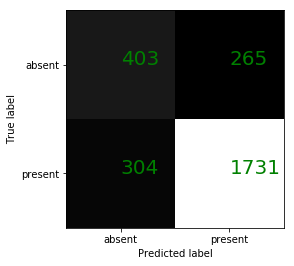

0.8087310395856456
[[ 408  260]
 [ 257 1778]]


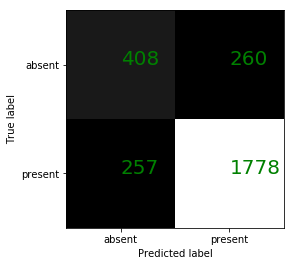

0.8435072142064373
[[ 465  203]
 [ 220 1815]]


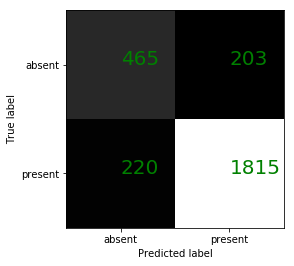

0.808361080281169
[[ 285  383]
 [ 135 1900]]


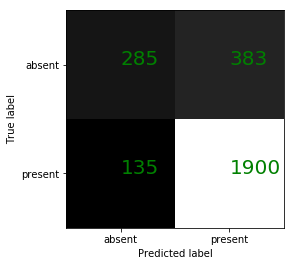

0.7528671846096929
[[   0  668]
 [   0 2035]]


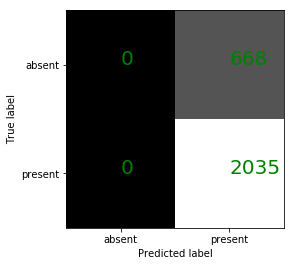

In [47]:
# Use scikit-learn to train a model with the training features we've extracted
from sklearn.svm import SVC
# Lets use a SVC with folowing C parameters: 
params = [10, 1, 0.1, 0.01, 0.001]

for c in params:
    clf = SVC(C=c)

    # Fit (=train) the model
    clf.fit(train_features_scaled, y_train)
    
    # save the model to disk
    #filename = 'finalized_model_SVM_'+str(c)+'_VGGish.sav'
    #print (filename)
    #joblib.dump(clf, filename)
    
    # Now lets predict the labels of the test data!
    predictions = clf.predict(test_features_scaled)
    # SVM Accuracy
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    print(accuracy)
    
    # lets compute the show the confusion matrix:
    cm = sklearn.metrics.confusion_matrix(y_test, predictions)
    print(cm)
    
    plot_cm(cm)

In [ ]:
# Now lets predict the labels of the test data!
predictions = clf.predict(test_features_scaled)

In [ ]:
# Biased Guess Accuracy
ones = np.ones(len(predictions))
accuracy = sklearn.metrics.accuracy_score(y_test, ones)
print(accuracy)

In [ ]:
# SVM Accuracy
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print(accuracy)

In [ ]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(y_test, predictions)
print(cm)

### Random Forest Classifier without scaler

In [ ]:
# Use scikit-learn to train a model with the training features we've extracted
from sklearn.ensemble import RandomForestClassifier

results_rf = pd.DataFrame(columns=['classifier','parameter','accuracy', 'cm', 'features'])

classifier = 'RF'
features = 'MFCC, VV, FL'

for train_index, test_index in kf.split(X,y):


    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    params = [100]#[10, 20, 50, 100]

    for estimators in params:
        clf3 = RandomForestClassifier(n_estimators=estimators)

        # Fit (=train) the model
        clf3.fit(X_train, y_train)

        # save the model to disk
        #filename = 'finalized_model_RF_'+str(estimators)+'_'+features+'_'+str(n_split)+'.sav'
        #print (filename)
        #joblib.dump(clf3, filename)

        # Now lets predict the labels of the test data!
        predictions = clf3.predict(X_test)
        # We can use sklearn to compute the accuracy score
        accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
        print(accuracy)

        # lets compute the show the confusion matrix:
        cm = sklearn.metrics.confusion_matrix(y_test, predictions)
        print(cm)
        
        results_rf.loc[results_rf.index.max() + 1] = [classifier, estimators, accuracy, cm, features]

TRAIN: [296471 296472 296473 ... 616689 616690 616691] TEST: [     0      1      2 ... 311436 311437 311438]


In [31]:
results_rf

,classifier,parameter,accuracy,cm,features
NaN,RF,100,0.730955,"[[16555, 32063], [7115, 89886]]","MFCC, VV, FL"


In [23]:
results_rf.to_pickle('results_random_forest_m-v-f.pkl')

In [24]:
results_rf = pd.read_pickle('results_random_forest.pkl')
results_rf_3 = pd.read_pickle('results_random_forest_m-v-f.pkl')

In [32]:
results_rf

,classifier,parameter,accuracy,cm,features
0,RF,10,0.744083,"[[545, 573], [119, 1467]]",MFCC
1,RF,20,0.745192,"[[503, 615], [74, 1512]]",MFCC
2,RF,50,0.735207,"[[465, 653], [63, 1523]]",MFCC
3,RF,100,0.744453,"[[467, 651], [40, 1546]]",MFCC
4,RF,10,0.765533,"[[508, 490], [144, 1562]]",MFCC
5,RF,20,0.728920,"[[423, 575], [158, 1548]]",MFCC
6,RF,50,0.735577,"[[414, 584], [131, 1575]]",MFCC
7,RF,100,0.732618,"[[398, 600], [123, 1583]]",MFCC
8,RF,10,0.786243,"[[707, 166], [412, 1419]]",MFCC
9,RF,20,0.796598,"[[729, 144], [406, 1425]]",MFCC


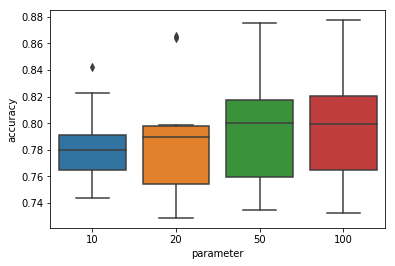

[(0.6, 1.0)]

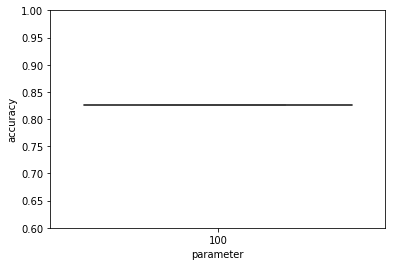

In [30]:
import seaborn as sns 
ax = sns.boxplot(x="parameter", y="accuracy", data=results_rf)
plt.show()
ax = sns.boxplot(x="parameter", y="accuracy", data=results_rf_3)
ax.set(ylim=(.60, 1.00))

0.7920828708842027
[[ 419  249]
 [ 313 1722]]


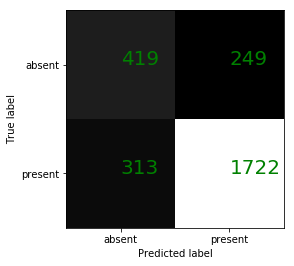

0.8079911209766926
[[ 416  252]
 [ 267 1768]]


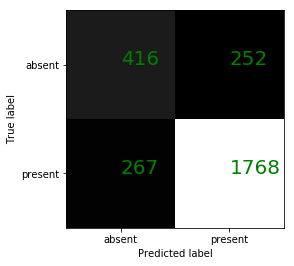

0.8161302256751757
[[ 395  273]
 [ 224 1811]]


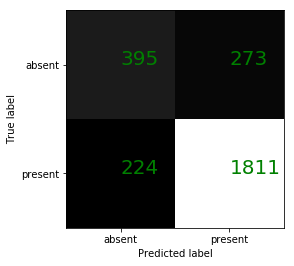

0.8205697373288938
[[ 394  274]
 [ 211 1824]]


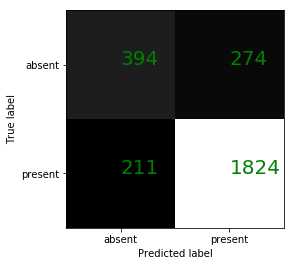

In [17]:
from sklearn.ensemble import RandomForestClassifier

params = [10, 20, 50, 100]

for estimators in params:
    clf3 = RandomForestClassifier(n_estimators=estimators)

    # Fit (=train) the model
    clf3.fit(X_train, y_train)
    
    # save the model to disk
    #filename = 'finalized_model_RF_'+str(estimators)+'_VGGish.sav'
    #print (filename)
    #joblib.dump(clf3, filename)
    
    # Now lets predict the labels of the test data!
    predictions = clf3.predict(X_test)
    # We can use sklearn to compute the accuracy score
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    print(accuracy)
    
    # lets compute the show the confusion matrix:
    cm = sklearn.metrics.confusion_matrix(y_test, predictions)
    print(cm)
    
    plot_cm(cm)

In [ ]:
# Now lets predict the labels of the test data!
predictions = clf3.predict(X)

In [ ]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(y, predictions)
print(accuracy)

In [ ]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(y, predictions)
print(cm)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

In [ ]:
# Evaluate with Precision, Recall and F-score

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, predictions)


In [ ]:
from inspect import signature
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, predictions)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Singing Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
